In [1]:
!pip install lightgbm xgboost


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [3]:
# Load Titanic dataset
train_df = pd.read_csv(r"C:\Users\CS\Desktop\Titanic_train.csv")
test_df = pd.read_csv(r"C:\Users\CS\Desktop\Titanic_test.csv")

# Preview dataset
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check for missing values
train_df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

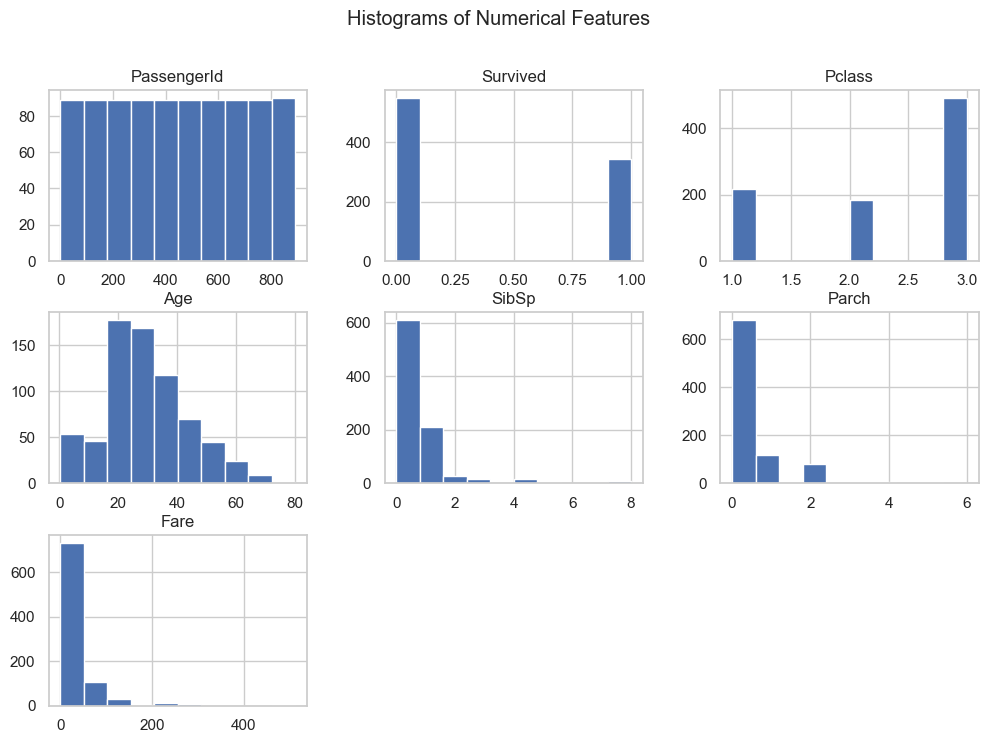

In [5]:
# Histograms for numerical features
train_df.hist(figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()


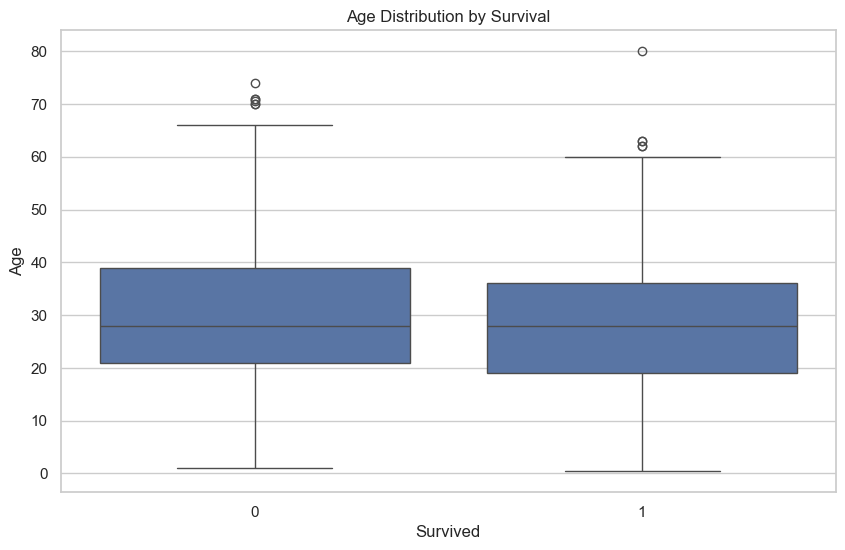

In [6]:
# Box plot for Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Age', data=train_df)
plt.title('Age Distribution by Survival')
plt.show()

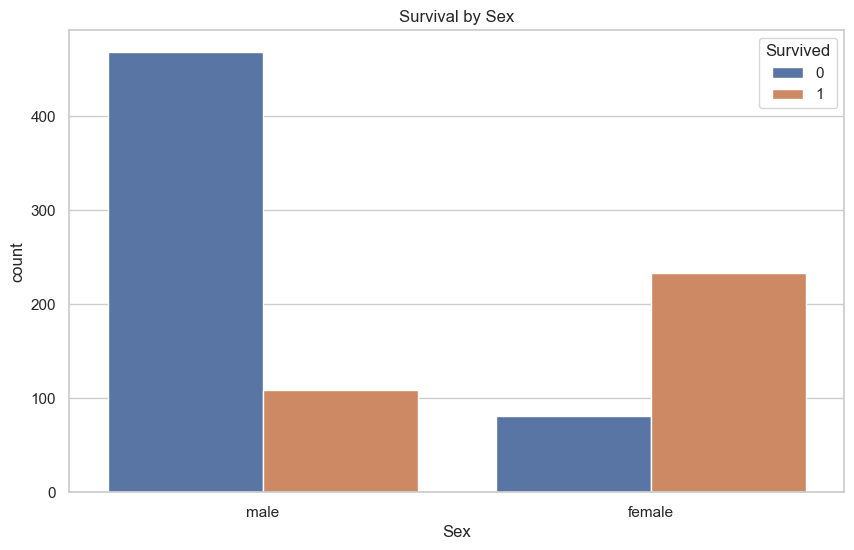

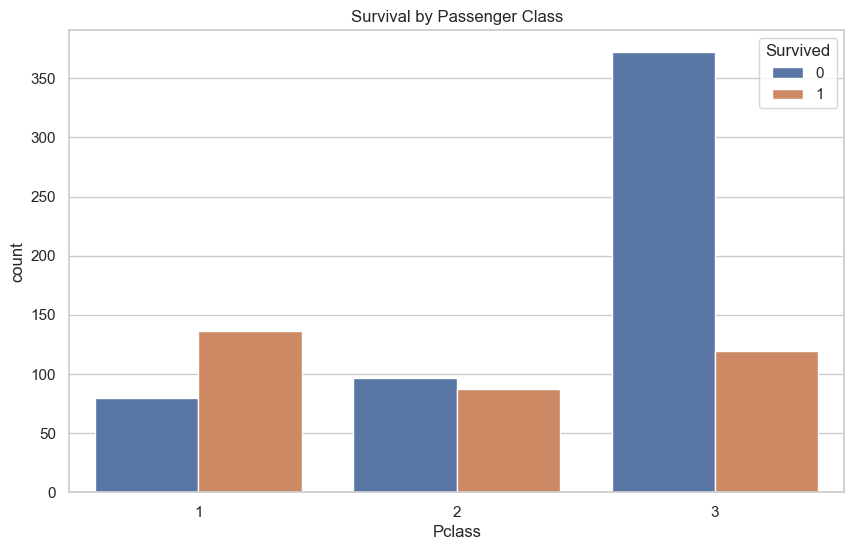

In [7]:
# Bar plots for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Sex')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

In [8]:
# Combine train and test for consistent preprocessing
full_df = pd.concat([train_df, test_df], sort=False)

# Fill missing values
full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['Fare'].fillna(full_df['Fare'].median(), inplace=True)
full_df['Embarked'].fillna(full_df['Embarked'].mode()[0], inplace=True)
full_df['Cabin'].fillna('Unknown', inplace=True)

# Drop Ticket and Name (less useful)
full_df.drop(['Ticket', 'Name'], axis=1, inplace=True)

# One-hot encode categorical variables
full_df = pd.get_dummies(full_df, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)

# Split back into train and test
train_df = full_df[~full_df['Survived'].isnull()]
test_df = full_df[full_df['Survived'].isnull()].drop('Survived', axis=1)


In [9]:
# Prepare training and validation sets
X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Hyperparameter tuning for LightGBM using GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

lgb_model = lgb.LGBMClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=cv, scoring='f1', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

best_lgb_model = lgb_grid.best_estimator_
print("Best LightGBM Parameters:", lgb_grid.best_params_)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [11]:
# Hyperparameter tuning for XGBoost using GridSearchCV
xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

best_xgb_model = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)


Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [12]:
# LightGBM model after hyperparameter tuning
best_lgb_model.fit(X_train, y_train)
lgb_preds = best_lgb_model.predict(X_val)

print("LightGBM Performance After Tuning:")
print(classification_report(y_val, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [13]:
# XGBoost model after hyperparameter tuning
best_xgb_model.fit(X_train, y_train)
xgb_preds = best_xgb_model.predict(X_val)

print("XGBoost Performance After Tuning:")
print(classification_report(y_val, xgb_preds))


XGBoost Performance After Tuning:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       105
         1.0       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [14]:
# LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_val)

print("LightGBM Performance:")
print(classification_report(y_val, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [15]:
# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("XGBoost Performance:")
print(classification_report(y_val, xgb_preds))


XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       105
         1.0       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



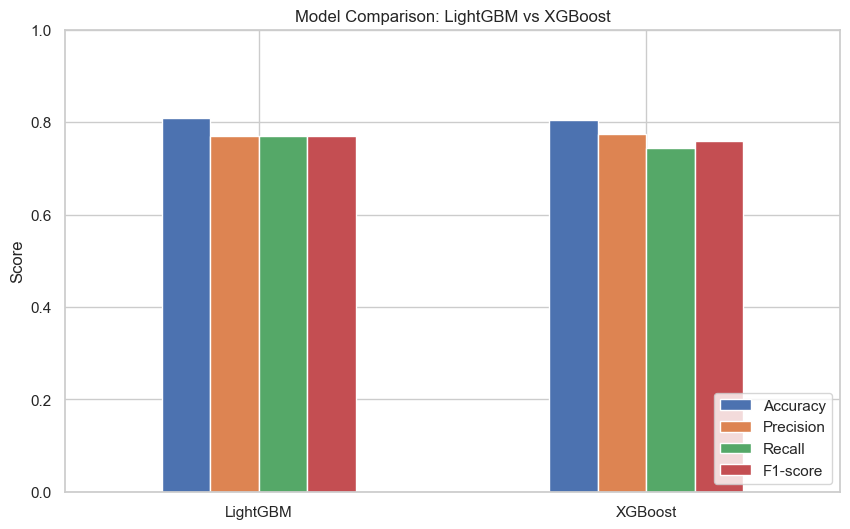

In [16]:
# Comparison of metrics
scores = {
    "Accuracy": [accuracy_score(y_val, lgb_preds), accuracy_score(y_val, xgb_preds)],
    "Precision": [precision_score(y_val, lgb_preds), precision_score(y_val, xgb_preds)],
    "Recall": [recall_score(y_val, lgb_preds), recall_score(y_val, xgb_preds)],
    "F1-score": [f1_score(y_val, lgb_preds), f1_score(y_val, xgb_preds)]
}
score_df = pd.DataFrame(scores, index=['LightGBM', 'XGBoost'])

score_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison: LightGBM vs XGBoost')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()
